In [1]:
%load_ext autoreload
%autoreload 2

from Classes_and_functions import imports

from Classes_and_functions.Dataloader import load_datasets
from Classes_and_functions.Dataloader import load_real_datasets
from Classes_and_functions.Dataloader import functions

from Classes_and_functions.Model import model_classes

from Classes_and_functions.Training import train_epochs
from Classes_and_functions.Training import functions as training_functions
from Classes_and_functions.Training import visualize_results

from Classes_and_functions.Real import functions as real_functions
from Classes_and_functions.Real import load_only_real

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = imports.SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 25705
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


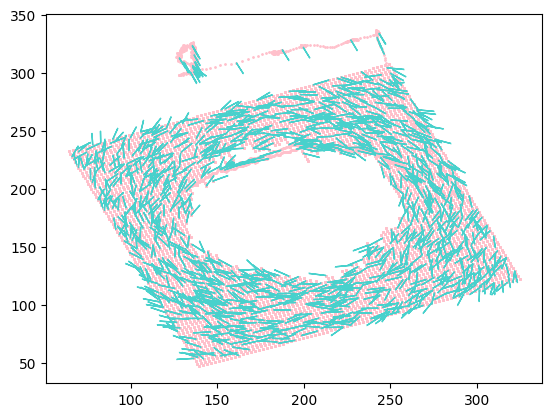

In [8]:
functions.plot_train_data(train_data)

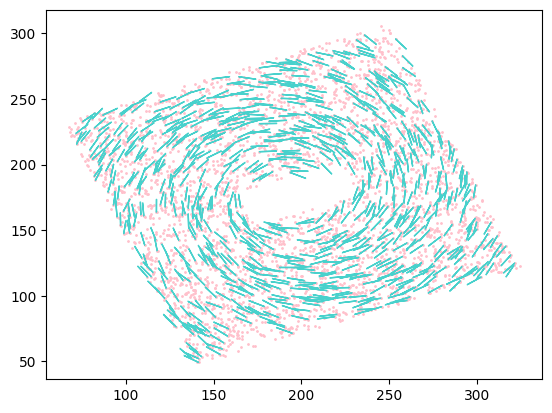

In [9]:
functions.plot_data(val_data)

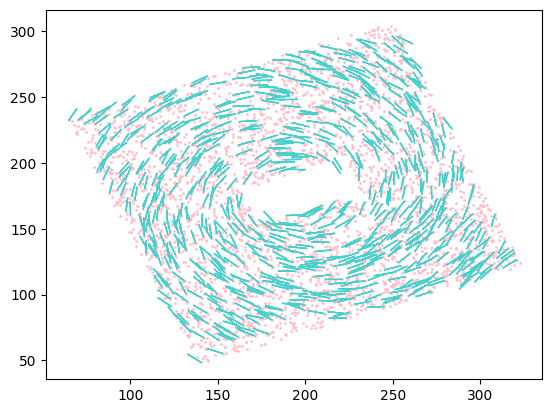

In [10]:
functions.plot_data(test_data)

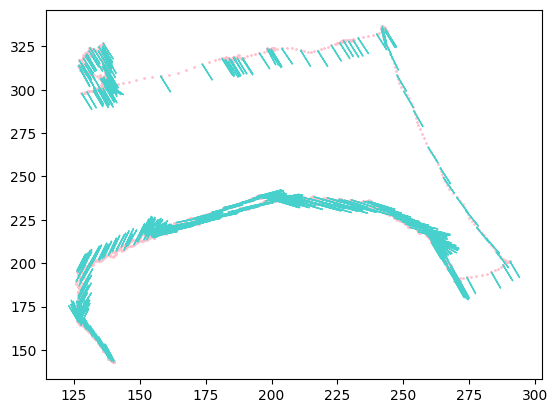

In [11]:
functions.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = imports.np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation pre filtering: 4000


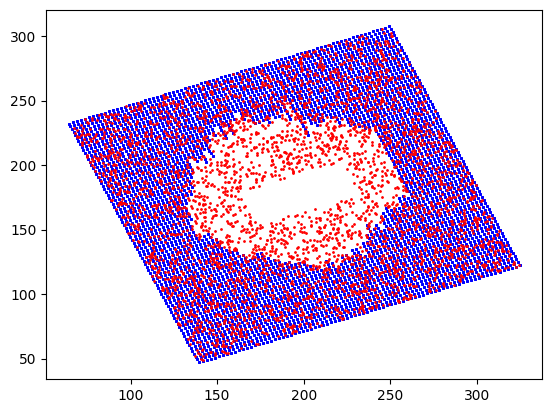

In [13]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation pre filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1944.66it/s]


Validation post filtering: 3253


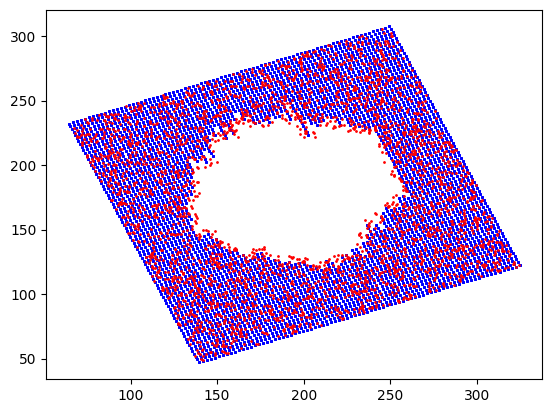

In [14]:
functions.filter_data(train_data, val_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation post filtering: " + str(len(val_data.imgs)))

Test pre filtering: 4000


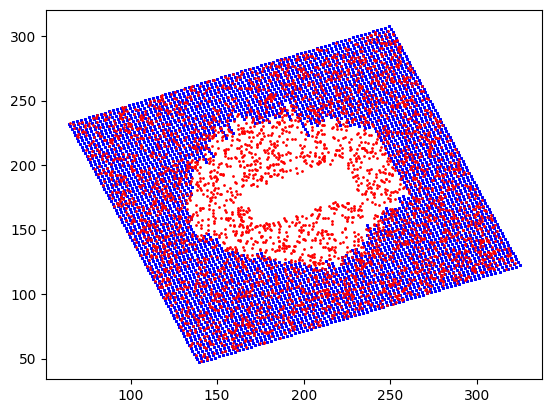

In [15]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test pre filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1936.91it/s]


Test post filtering: 3271


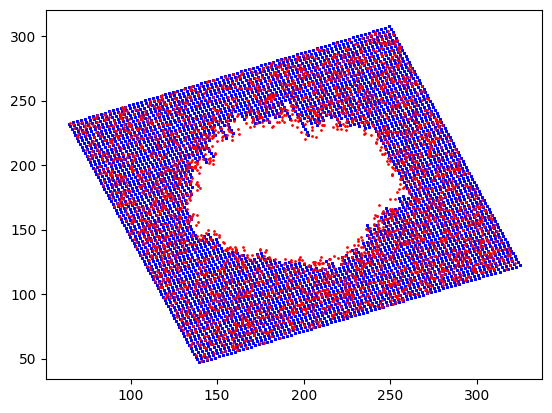

In [16]:
functions.filter_data(train_data, test_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test post filtering: " + str(len(test_data.imgs)))

dist matrix tensor([1.4142, 1.4142, 1.4142, 1.4142, 1.4142])
cand tensor([212.3443, 182.3443, 167.3443, 152.3443, 197.3443])
yaw_deg 78.67284
diff yaw tensor([133.6715, 103.6715,  88.6715,  73.6715, 118.6715])
iou: 0.827949099339533
yaw difference tensor(16.3285) deg
localization error:  0.14212897 meters


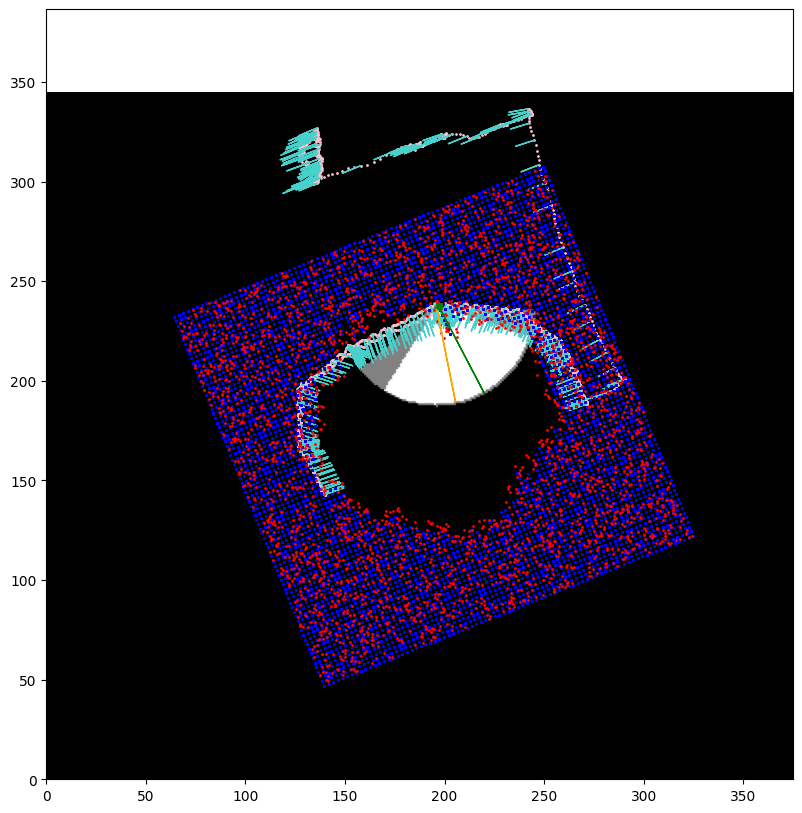

<Figure size 640x480 with 0 Axes>

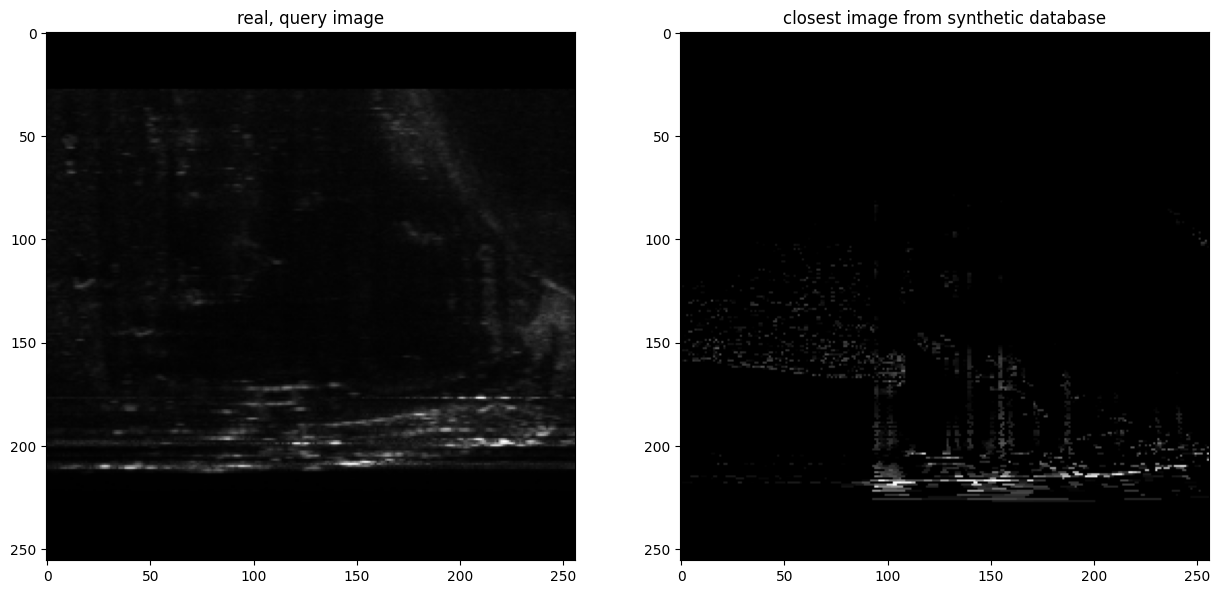

In [17]:
functions.localization(train_data, val_data, real_data)

In [18]:
batch = 16
train_dataloader = imports.DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [19]:
net = model_classes.Model().cuda()
net.train()

optimizer = imports.torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = imports.torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = imports.torch.nn.Dropout(0.3).cuda()

In [20]:
locacriterion = imports.torch.nn.CrossEntropyLoss().cuda()
recocriterion = imports.torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [21]:
train_epochs.train_epochs(writer, train_data, train_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)

  1%|▍                                        | 18/1501 [00:18<25:21,  1.03s/it]


KeyboardInterrupt: 

In [23]:
training_functions.get_descriptors(train_data, val_data, net)

  2%|▌                                      | 362/24005 [00:03<04:18, 91.41it/s]


KeyboardInterrupt: 

## Visualize Training results on Validation data

### Load the checkpoint model

In [21]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model_classes.Model()
model_classes.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [22]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  0%|▏                                       | 96/24005 [00:01<05:12, 76.45it/s]


KeyboardInterrupt: 

In [23]:
val_data.computeDescriptors(net)

computing dataset descriptors


  4%|█▋                                      | 139/3253 [00:01<00:33, 93.70it/s]


KeyboardInterrupt: 

### Visualize query results: sonar images

In [24]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-6.5092, device='cuda:0', grad_fn=<MinBackward1>) tensor(8.8661, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4664, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.3115, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5306, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4714, device='cuda:0', grad_fn=<MaxBackward1>)


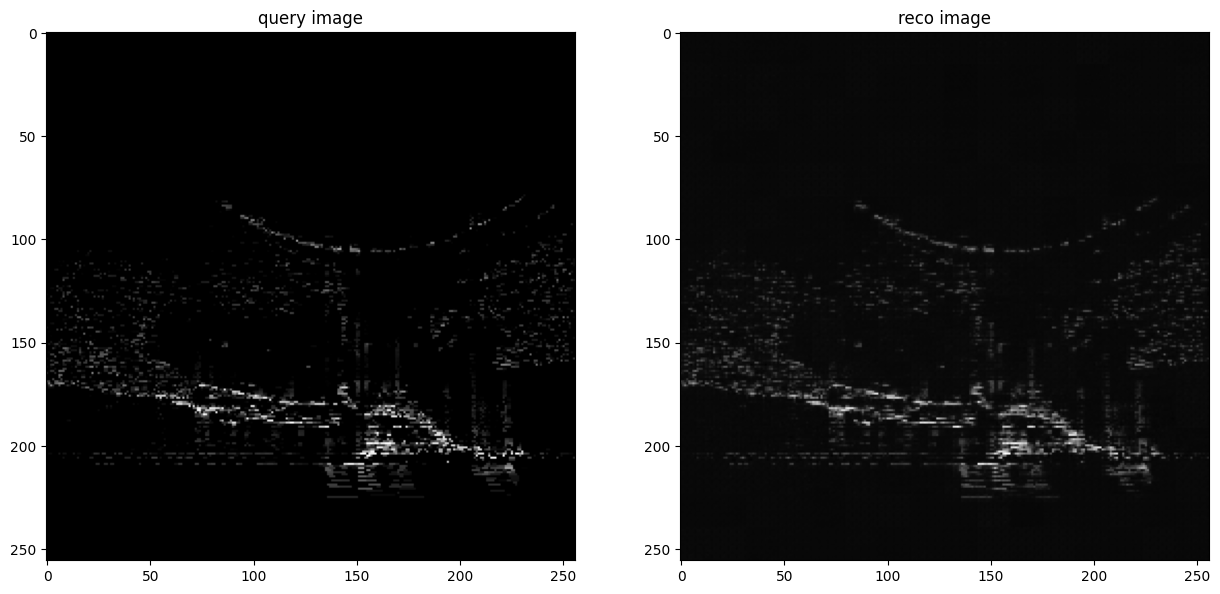

In [25]:
visualize_results.analyze_feature_robustness(train_data, net)

In [26]:
val_dataloader = imports.DataLoader(val_data, batch_size=batch, shuffle=True)

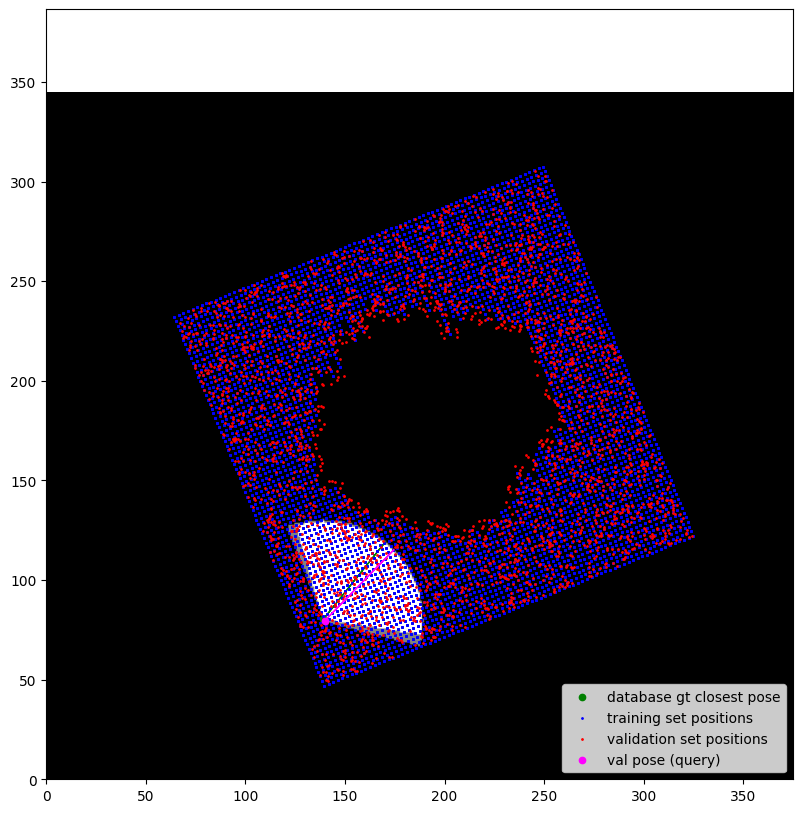

<Figure size 640x480 with 0 Axes>

In [27]:
_, _, gtpose, _, _, _ = next(iter(val_dataloader))
gt_pose = gtpose[0]
visualize_results.check_process(gt_pose, train_data, val_data, plot=True)

In [28]:
for batch in val_dataloader:
    _, _, gtpose, _, _, _ = batch
    gt_pose = gtpose[0]
    visualize_results.check_process(gt_pose, train_data, val_data, plot=False)
# nothing printed means check ok

its me
dist matrix tensor([0.6374, 0.6374, 0.6374, 0.6374, 0.6374])
cand tensor([274.2103, 229.2103, 244.2103, 259.2103, 289.2103])
yaw_deg 265.49583435058594
diff yaw tensor([ 8.7145, 36.2855, 21.2855,  6.2855, 23.7145])
iou: 0.0
localization error: 16.0176 meters
orientation error : 169.1633 degrees


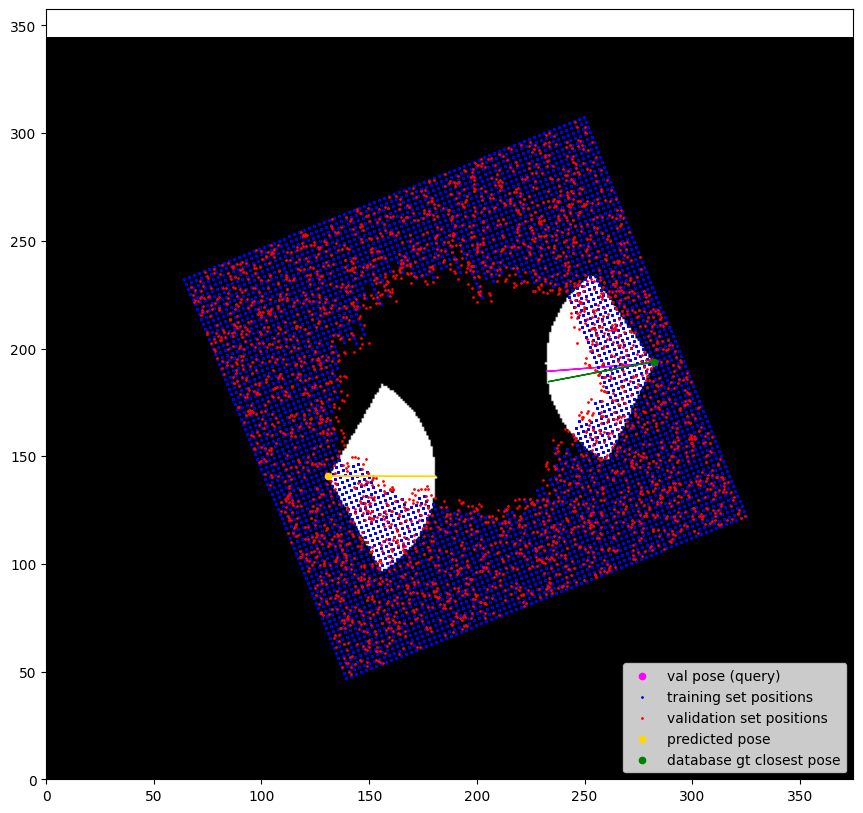

<Figure size 640x480 with 0 Axes>

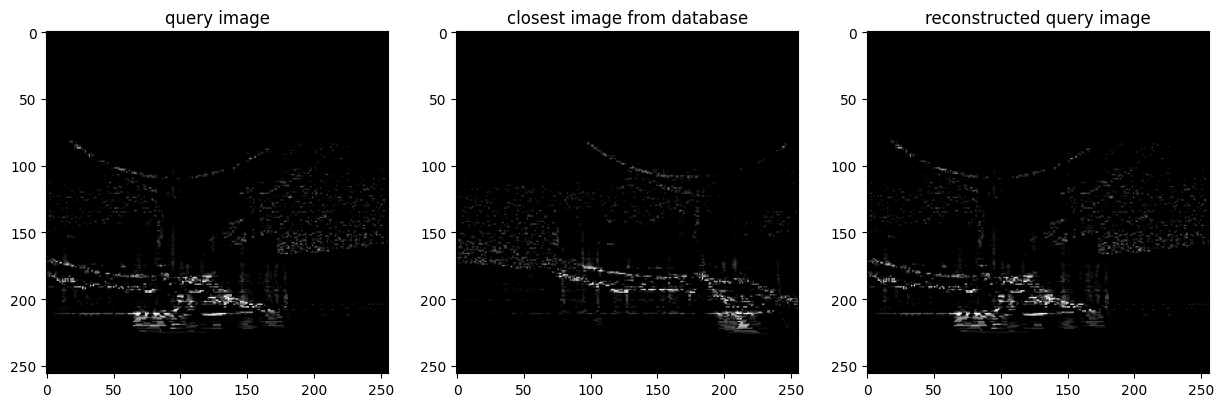

In [40]:
query_idx = imports.random.randint(0, len(val_data))

loca_error, orie_error = visualize_results.process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [47]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(val_data))):
    loca_error, orie_error = visualize_results.process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = imports.np.array(loca_errors).mean()
avg_orie_error = imports.np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  2%|█                                        | 81/3253 [00:02<01:25, 36.90it/s]


KeyboardInterrupt: 

In [43]:
loca_errors = imports.np.array(loca_errors)
orie_errors = imports.np.array(orie_errors)

In [44]:
loca_errors.argmax()

np.int64(1321)

In [45]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

5.391367
43.923233


## Visualize Training results on Test data

### Load the checkpoint model

In [57]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model_classes.Model()
model_classes.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [58]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  0%|▏                                      | 108/24005 [00:01<04:24, 90.19it/s]


KeyboardInterrupt: 

### Visualize query results: sonar images

In [59]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-11.2580, device='cuda:0', grad_fn=<MinBackward1>) tensor(10.9705, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4682, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.2391, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0088, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5549, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5747, device='cuda:0', grad_fn=<MaxBackward1>)


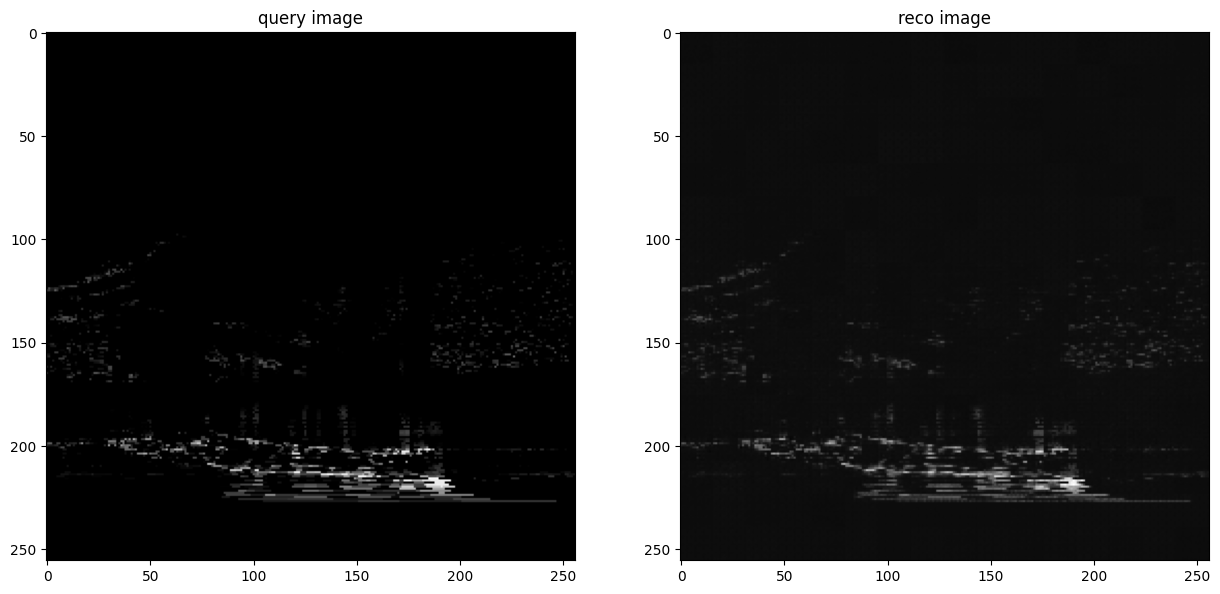

In [60]:
visualize_results.analyze_feature_robustness(train_data, net)

its me
dist matrix tensor([0.2795, 0.2795, 0.2795, 0.2795, 0.2795])
cand tensor([109.5898,  64.5898,  79.5898,  49.5898,  94.5898])
yaw_deg 174.36917877197266
diff yaw tensor([ 64.7794, 109.7794,  94.7794, 124.7794,  79.7794])
iou: 0.0
localization error: 18.2637 meters
orientation error : 101.4407 degrees


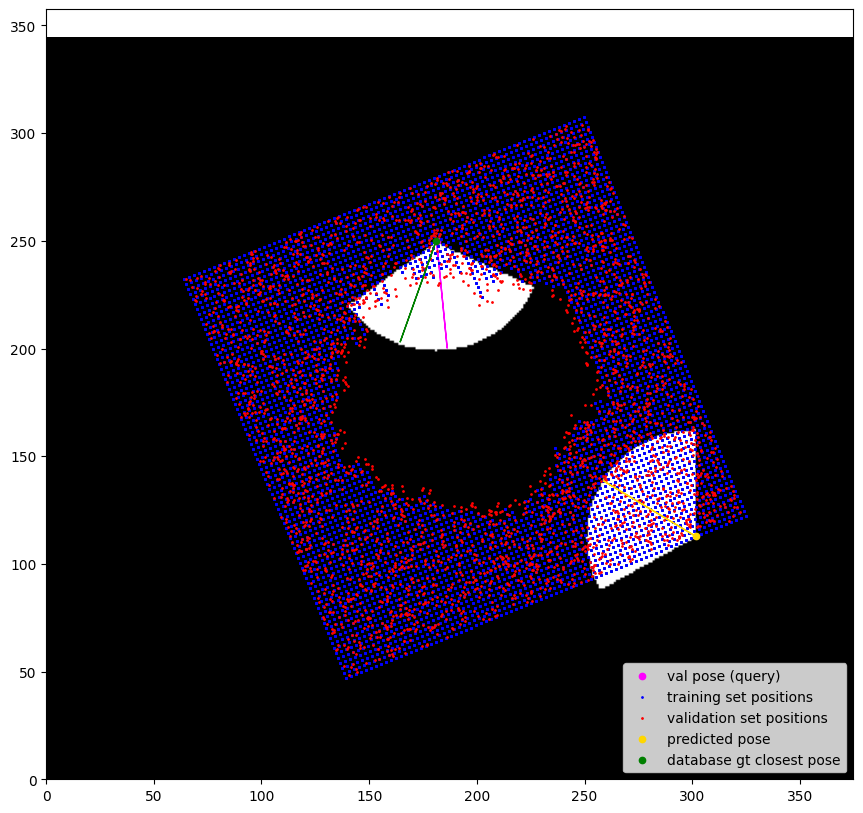

<Figure size 640x480 with 0 Axes>

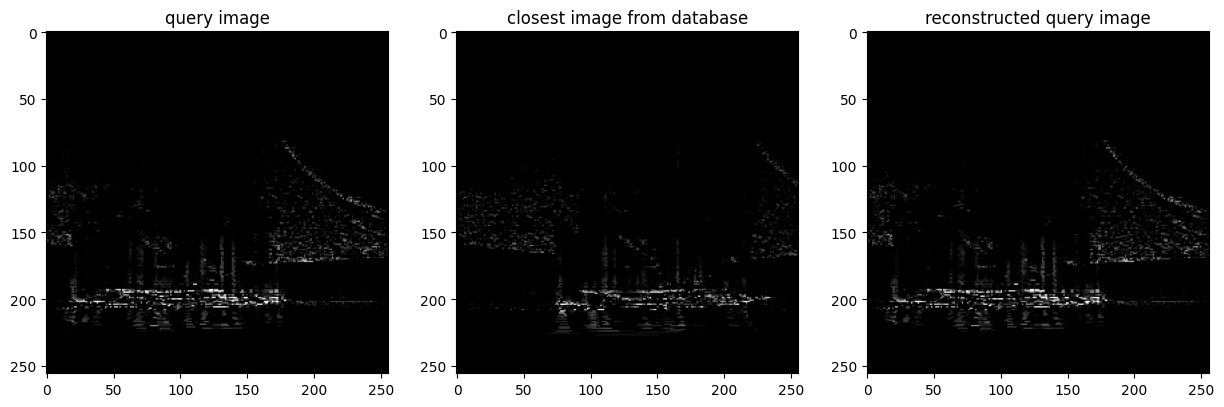

In [32]:
query_idx = imports.random.randint(0, len(test_data))

loca_error, orie_error = visualize_results.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [27]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualize_results.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  0%|                                          | 4/3271 [00:00<01:37, 33.52it/s]

its me
dist matrix tensor([1.0717, 1.0717, 1.0717, 1.0717, 1.0717])
cand tensor([-134.9746,  -89.9746, -119.9746,  -74.9746, -104.9746])
yaw_deg 355.2602844238281
diff yaw tensor([130.2349,  85.2349, 115.2349,  70.2349, 100.2349])
its me
dist matrix tensor([0.9014, 0.9014, 0.9014, 0.9014, 0.9014])
cand tensor([ 58.8065,  43.8065,  88.8065,  73.8065, 103.8065])
yaw_deg 193.1123504638672
diff yaw tensor([134.3058, 149.3058, 104.3058, 119.3058,  89.3058])
its me
dist matrix tensor([0.8570, 0.8570, 0.8570, 0.8570, 0.8570])
cand tensor([-150.9803, -105.9803,  -90.9803, -135.9803, -120.9803])
yaw_deg 350.7396469116211
diff yaw tensor([141.7199,  96.7199,  81.7199, 126.7199, 111.7199])
its me
dist matrix tensor([3.9031, 3.9031, 3.9031, 3.9031, 3.9031])
cand tensor([100.2863,  40.2863,  55.2863,  70.2863,  85.2863])
yaw_deg 188.89824676513672
diff yaw tensor([ 88.6119, 148.6119, 133.6119, 118.6119, 103.6119])
its me
dist matrix tensor([0.9922, 0.9922, 0.9922, 0.9922, 0.9922])
cand tensor([ 31.

  0%|▏                                        | 12/3271 [00:00<01:33, 34.82it/s]

dist matrix tensor([1.3919, 1.3919, 1.3919, 1.3919, 1.3919])
cand tensor([-124.2807,  -94.2807, -109.2807,  -64.2807,  -79.2807])
yaw_deg 8.130630493164062
diff yaw tensor([132.4113, 102.4114, 117.4114,  72.4114,  87.4114])
its me
dist matrix tensor([1.1792, 1.1792, 1.1792, 1.1792, 1.1792])
cand tensor([ 4.2103, 34.2103, 49.2103, 19.2103, 64.2103])
yaw_deg 138.36107635498047
diff yaw tensor([134.1508, 104.1508,  89.1508, 119.1508,  74.1508])
its me
dist matrix tensor([1.1524, 1.1524, 1.1524, 1.1524, 1.1524])
cand tensor([-170.7674, -140.7674, -155.7674, -125.7674, -185.7674])
yaw_deg 313.5632781982422
diff yaw tensor([124.3307,  94.3307, 109.3307,  79.3307, 139.3307])
its me
dist matrix tensor([1.2990, 1.2990, 1.2990, 1.2990, 1.2990])
cand tensor([52.9004, -7.0996, 37.9004, 22.9004,  7.9004])
yaw_deg 125.68954086303711
diff yaw tensor([ 72.7892, 132.7892,  87.7892, 102.7892, 117.7892])
its me
dist matrix tensor([1.0308, 1.0308, 1.0308, 1.0308, 1.0308])
cand tensor([-175.7897, -145.7897

  1%|▎                                        | 20/3271 [00:00<01:28, 36.54it/s]

its me
dist matrix tensor([1.1319, 1.1319, 1.1319, 1.1319, 1.1319])
cand tensor([131.9260, 101.9260, 146.9260, 161.9260, 116.9260])
yaw_deg 222.6907196044922
diff yaw tensor([ 90.7647, 120.7647,  75.7647,  60.7647, 105.7647])
its me
dist matrix tensor([0.7421, 0.7421, 0.7421, 0.7421, 0.7421])
cand tensor([-46.8272, -16.8272, -31.8272,  -1.8272, -61.8272])
yaw_deg 60.57231521606445
diff yaw tensor([107.3995,  77.3995,  92.3995,  62.3995, 122.3995])
its me
dist matrix tensor([2.5526, 2.5526, 2.5526, 2.5526, 2.5526])
cand tensor([-22.3547, -37.3547, -67.3547, -52.3547,  -7.3547])
yaw_deg 55.65690994262695
diff yaw tensor([ 78.0116,  93.0116, 123.0116, 108.0116,  63.0116])
its me
dist matrix tensor([0.7016, 0.7016, 0.7016, 0.7016, 0.7016])
cand tensor([ 18.0013,  48.0013,  33.0013, -11.9987,   3.0013])
yaw_deg 134.6895637512207
diff yaw tensor([116.6883,  86.6883, 101.6883, 146.6883, 131.6883])
its me
dist matrix tensor([0.3536, 0.3536, 0.3536, 0.3536, 0.3536])
cand tensor([-55.9857, -25.9

  1%|▎                                        | 28/3271 [00:00<01:29, 36.28it/s]

dist matrix tensor([1.2748, 1.2748, 1.2748, 1.2748, 1.2748])
cand tensor([105.9259,  90.9259,  60.9259, 120.9259,  75.9259])
yaw_deg 182.9881820678711
diff yaw tensor([ 77.0623,  92.0623, 122.0623,  62.0623, 107.0623])
its me
dist matrix tensor([0.8478, 0.8478, 0.8478, 0.8478, 0.8478])
cand tensor([-152.2005, -167.2005, -182.2005, -137.2005, -122.2005])
yaw_deg 297.4029998779297
diff yaw tensor([ 89.6035, 104.6035, 119.6035,  74.6035,  59.6035])
its me
dist matrix tensor([1.1040, 1.1040, 1.1040, 1.1040, 1.1040])
cand tensor([-110.3639, -140.3639,  -80.3639, -125.3639,  -95.3639])
yaw_deg 352.46653747558594
diff yaw tensor([102.8304, 132.8304,  72.8304, 117.8304,  87.8304])
its me
dist matrix tensor([1.4790, 1.4790, 1.4790, 1.4790, 1.4790])
cand tensor([ 67.8318,  97.8318,  52.8318,  82.8318, 112.8318])
yaw_deg 189.2981719970703
diff yaw tensor([121.4664,  91.4664, 136.4664, 106.4664,  76.4664])
its me
dist matrix tensor([1.3405, 1.3405, 1.3405, 1.3405, 1.3405])
cand tensor([ -97.1682, 

  1%|▍                                        | 38/3271 [00:01<01:23, 38.83it/s]

dist matrix tensor([0.4330, 0.4330, 0.4330, 0.4330, 0.4330])
cand tensor([ 98.8641,  83.8641,  68.8641, 128.8642, 113.8641])
yaw_deg 207.70902252197266
diff yaw tensor([108.8449, 123.8449, 138.8449,  78.8449,  93.8449])
its me
dist matrix tensor([1.0698, 1.0698, 1.0698, 1.0698, 1.0698])
cand tensor([-63.2855, -33.2855, -48.2855, -78.2855, -93.2855])
yaw_deg 36.675392150878906
diff yaw tensor([ 99.9609,  69.9609,  84.9609, 114.9609, 129.9609])
its me
dist matrix tensor([1.2087, 1.2087, 1.2087, 1.2087, 1.2087])
cand tensor([-76.6593, -46.6593, -61.6593, -91.6593, -31.6593])
yaw_deg 39.40553665161133
diff yaw tensor([116.0648,  86.0648, 101.0648, 131.0648,  71.0648])
its me
dist matrix tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500])
cand tensor([-90.1884, -60.1884, -75.1884, -45.1884, -30.1884])
yaw_deg 55.06045913696289
diff yaw tensor([145.2488, 115.2488, 130.2488, 100.2488,  85.2488])
its me
dist matrix tensor([0.6250, 0.6250, 0.6250, 0.6250, 0.6250])
cand tensor([105.0254,  90.0254, 

  1%|▌                                        | 46/3271 [00:01<01:21, 39.33it/s]

its me
dist matrix tensor([1.1726, 1.1726, 1.1726, 1.1726, 1.1726])
cand tensor([121.0990,  76.0990, 106.0990,  91.0990,  61.0990])
yaw_deg 200.51210021972656
diff yaw tensor([ 79.4131, 124.4131,  94.4131, 109.4131, 139.4131])
its me
dist matrix tensor([1.1456, 1.1456, 1.1456, 1.1456, 1.1456])
cand tensor([-151.2620, -196.2620, -181.2620, -166.2620, -136.2620])
yaw_deg 294.32908630371094
diff yaw tensor([ 85.5911, 130.5911, 115.5911, 100.5911,  70.5911])
its me
dist matrix tensor([1.2311, 1.2311, 1.2311, 1.2311, 1.2311])
cand tensor([ -95.5085, -140.5085, -110.5085,  -80.5085, -125.5085])
yaw_deg 346.99822998046875
diff yaw tensor([ 82.5067, 127.5067,  97.5067,  67.5067, 112.5067])
its me
dist matrix tensor([0.9803, 0.9803, 0.9803, 0.9803, 0.9803])
cand tensor([ -96.8432,  -66.8432,  -81.8432,  -51.8432, -111.8432])
yaw_deg 9.388275146484375
diff yaw tensor([106.2315,  76.2315,  91.2315,  61.2314, 121.2315])
its me
dist matrix tensor([0.9014, 0.9014, 0.9014, 0.9014, 0.9014])
cand tenso

  2%|▋                                        | 50/3271 [00:01<01:23, 38.66it/s]

its me
dist matrix tensor([0.9763, 0.9763, 0.9763, 0.9763, 0.9763])
cand tensor([178.0367, 193.0367, 148.0367, 163.0367, 208.0367])
yaw_deg 288.4410705566406
diff yaw tensor([110.4044,  95.4044, 140.4044, 125.4044,  80.4044])
its me
dist matrix tensor([0.8004, 0.8004, 0.8004, 0.8004, 0.8004])
cand tensor([-168.9198, -138.9198, -183.9198, -153.9198, -123.9198])
yaw_deg 306.5262145996094
diff yaw tensor([115.4460,  85.4460, 130.4460, 100.4460,  70.4460])
its me
dist matrix tensor([0.4419, 0.4419, 0.4419, 0.4419, 0.4419])
cand tensor([-123.1292,  -63.1292,  -78.1292,  -93.1292, -108.1292])
yaw_deg 4.805183410644531
diff yaw tensor([127.9344,  67.9344,  82.9344,  97.9344, 112.9344])
its me
dist matrix tensor([0.6374, 0.6374, 0.6374, 0.6374, 0.6374])
cand tensor([ 30.7340,  15.7340,   0.7340, -29.2660, -14.2660])
yaw_deg 106.54472923278809
diff yaw tensor([ 75.8107,  90.8107, 105.8107, 135.8107, 120.8107])
its me
dist matrix tensor([0.5154, 0.5154, 0.5154, 0.5154, 0.5154])
cand tensor([113.

  2%|▋                                        | 54/3271 [00:01<01:33, 34.38it/s]

dist matrix tensor([0.6495, 0.6495, 0.6495, 0.6495, 0.6495])
cand tensor([-111.1359, -126.1359, -156.1358, -141.1358,  -96.1359])
yaw_deg 335.58548736572266
diff yaw tensor([ 86.7213, 101.7213, 131.7213, 116.7213,  71.7213])
its me
dist matrix tensor([1.2748, 1.2748, 1.2748, 1.2748, 1.2748])
cand tensor([109.2103, 139.2103, 154.2103,  94.2103, 124.2103])
yaw_deg 218.58375549316406
diff yaw tensor([109.3734,  79.3734,  64.3734, 124.3734,  94.3734])
its me
dist matrix tensor([0.8004, 0.8004, 0.8004, 0.8004, 0.8004])
cand tensor([-90.5533, -75.5533, -30.5533, -60.5533, -45.5533])
yaw_deg 34.02030563354492
diff yaw tensor([124.5736, 109.5736,  64.5736,  94.5736,  79.5736])
its me
dist matrix tensor([0.9520, 0.9520, 0.9520, 0.9520, 0.9520])
cand tensor([ 95.2395,  80.2395,  50.2395, 110.2395,  65.2395])
yaw_deg 195.44256591796875
diff yaw tensor([100.2031, 115.2031, 145.2031,  85.2031, 130.2031])
its me


  2%|▊                                        | 62/3271 [00:01<01:49, 29.40it/s]

dist matrix tensor([0.2795, 0.2795, 0.2795, 0.2795, 0.2795])
cand tensor([-180.6304, -195.6304, -150.6304, -135.6304, -165.6304])
yaw_deg 288.82696533203125
diff yaw tensor([109.4573, 124.4573,  79.4573,  64.4573,  94.4573])
its me
dist matrix tensor([0.4098, 0.4098, 0.4098, 0.4098, 0.4098])
cand tensor([ -8.6070, -23.6070, -38.6070,   6.3930, -53.6070])
yaw_deg 78.62048530578613
diff yaw tensor([ 87.2275, 102.2275, 117.2275,  72.2275, 132.2275])
its me
dist matrix tensor([1.2247, 1.2247, 1.2247, 1.2247, 1.2247])
cand tensor([134.4467, 104.4467, 149.4467,  89.4467, 119.4467])
yaw_deg 213.72908782958984
diff yaw tensor([ 79.2824, 109.2824,  64.2824, 124.2824,  94.2824])
its me
dist matrix tensor([0.5376, 0.5376, 0.5376, 0.5376, 0.5376])
cand tensor([-113.7751,  -83.7751,  -68.7751, -128.7751,  -98.7751])
yaw_deg 6.4232177734375
diff yaw tensor([120.1983,  90.1983,  75.1983, 135.1983, 105.1983])
its me
dist matrix tensor([1.1592, 1.1592, 1.1592, 1.1592, 1.1592])
cand tensor([109.4322,  9

  2%|▊                                        | 66/3271 [00:01<01:52, 28.43it/s]

dist matrix tensor([1.3170, 1.3170, 1.3170, 1.3170, 1.3170])
cand tensor([63.3637, 78.3637, 18.3637, 33.3637, 48.3637])
yaw_deg 162.96732330322266
diff yaw tensor([ 99.6036,  84.6036, 144.6036, 129.6036, 114.6036])
its me
dist matrix tensor([0.5078, 0.5078, 0.5078, 0.5078, 0.5078])
cand tensor([-107.5257,  -77.5257, -122.5257, -137.5257,  -92.5257])
yaw_deg 359.56949615478516
diff yaw tensor([107.0952,  77.0952, 122.0952, 137.0952,  92.0952])
its me
dist matrix tensor([1.1388, 1.1388, 1.1388, 1.1388, 1.1388])
cand tensor([  0.5203, -14.4797,  30.5203,  15.5203, -29.4797])
yaw_deg 104.72501564025879
diff yaw tensor([104.2048, 119.2048,  74.2048,  89.2048, 134.2048])
its me
dist matrix tensor([1.1388, 1.1388, 1.1388, 1.1388, 1.1388])
cand tensor([69.9058, 84.9058, 39.9058, 54.9058, 24.9058])
yaw_deg 165.5576629638672
diff yaw tensor([ 95.6519,  80.6519, 125.6519, 110.6519, 140.6519])
its me
dist matrix tensor([1.1659, 1.1659, 1.1659, 1.1659, 1.1659])
cand tensor([-124.8090, -154.8090, -1

  2%|▉                                        | 74/3271 [00:02<01:48, 29.51it/s]

its me
dist matrix tensor([0.5303, 0.5303, 0.5303, 0.5303, 0.5303])
cand tensor([145.4642, 130.4642, 115.4642,  85.4642, 100.4642])
yaw_deg 227.74937438964844
diff yaw tensor([ 82.2852,  97.2852, 112.2852, 142.2852, 127.2852])
its me
dist matrix tensor([1.4142, 1.4142, 1.4142, 1.4142, 1.4142])
cand tensor([-138.1031, -153.1031, -108.1032, -123.1032,  -93.1032])
yaw_deg 353.2864456176758
diff yaw tensor([131.3896, 146.3896, 101.3896, 116.3896,  86.3896])
its me
dist matrix tensor([1.3578, 1.3578, 1.3578, 1.3578, 1.3578])
cand tensor([-152.0044, -122.0044, -137.0044, -167.0044, -107.0044])
yaw_deg 320.5476379394531
diff yaw tensor([112.5520,  82.5520,  97.5520, 127.5520,  67.5520])
its me
dist matrix tensor([0.8660, 0.8660, 0.8660, 0.8660, 0.8660])
cand tensor([148.2235, 178.2235, 193.2235, 208.2235, 163.2235])
yaw_deg 296.5352478027344
diff yaw tensor([148.3117, 118.3117, 103.3117,  88.3117, 133.3117])
its me
dist matrix tensor([1.6630, 1.6630, 1.6630, 1.6630, 1.6630])
cand tensor([-31.

  3%|█                                        | 82/3271 [00:02<01:38, 32.41it/s]

its me
dist matrix tensor([1.5052, 1.5052, 1.5052, 1.5052, 1.5052])
cand tensor([-159.3902, -189.3902, -144.3902, -174.3902, -129.3902])
yaw_deg 314.9137420654297
diff yaw tensor([114.3040, 144.3040,  99.3040, 129.3040,  84.3040])
its me
dist matrix tensor([1.0458, 1.0458, 1.0458, 1.0458, 1.0458])
cand tensor([120.0667, 135.0667, 150.0667, 105.0667, 165.0667])
yaw_deg 248.39761352539062
diff yaw tensor([128.3309, 113.3309,  98.3309, 143.3309,  83.3309])
its me
dist matrix tensor([1.0533, 1.0533, 1.0533, 1.0533, 1.0533])
cand tensor([ -58.6709, -118.6709, -103.6709,  -88.6709,  -73.6709])
yaw_deg 7.033416748046875
diff yaw tensor([ 65.7043, 125.7043, 110.7043,  95.7043,  80.7043])
its me
dist matrix tensor([1.0533, 1.0533, 1.0533, 1.0533, 1.0533])
cand tensor([ 16.5602, -13.4398,  31.5602,   1.5602,  46.5602])
yaw_deg 121.98135757446289
diff yaw tensor([105.4212, 135.4212,  90.4212, 120.4212,  75.4212])
its me
dist matrix tensor([0.8292, 0.8292, 0.8292, 0.8292, 0.8292])
cand tensor([-52

  3%|█▏                                       | 90/3271 [00:02<01:34, 33.82it/s]

dist matrix tensor([0.7629, 0.7629, 0.7629, 0.7629, 0.7629])
cand tensor([-72.0916, -57.0916, -27.0916, -87.0916, -42.0916])
yaw_deg 45.580875396728516
diff yaw tensor([117.6725, 102.6725,  72.6725, 132.6725,  87.6725])
its me
dist matrix tensor([1.1388, 1.1388, 1.1388, 1.1388, 1.1388])
cand tensor([  5.9255, -39.0745, -54.0745,  -9.0745, -24.0745])
yaw_deg 69.64853858947754
diff yaw tensor([ 63.7231, 108.7231, 123.7231,  78.7231,  93.7231])
its me
dist matrix tensor([0.8660, 0.8660, 0.8660, 0.8660, 0.8660])
cand tensor([124.9725, 139.9725, 154.9725, 169.9725, 109.9725])
yaw_deg 243.9635009765625
diff yaw tensor([118.9910, 103.9910,  88.9910,  73.9910, 133.9910])
its me
dist matrix tensor([1.3919, 1.3919, 1.3919, 1.3919, 1.3919])
cand tensor([-121.9052, -181.9052, -136.9052, -151.9052, -166.9052])
yaw_deg 316.6165771484375
diff yaw tensor([ 78.5218, 138.5218,  93.5218, 108.5218, 123.5218])
its me
dist matrix tensor([0.9682, 0.9682, 0.9682, 0.9682, 0.9682])
cand tensor([-191.0179, -131.

KeyboardInterrupt: 

In [63]:
loca_errors = imports.np.array(loca_errors)
orie_errors = imports.np.array(orie_errors)

In [64]:
loca_errors.argmax()

np.int64(24)

In [65]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

4.7176623
36.883026


## process real images

query_idx: 432
266.44012 205.10986 1.8072953 -76.44961
iou: 0.6388185041832116
localization error Upper:  3.45032 meters


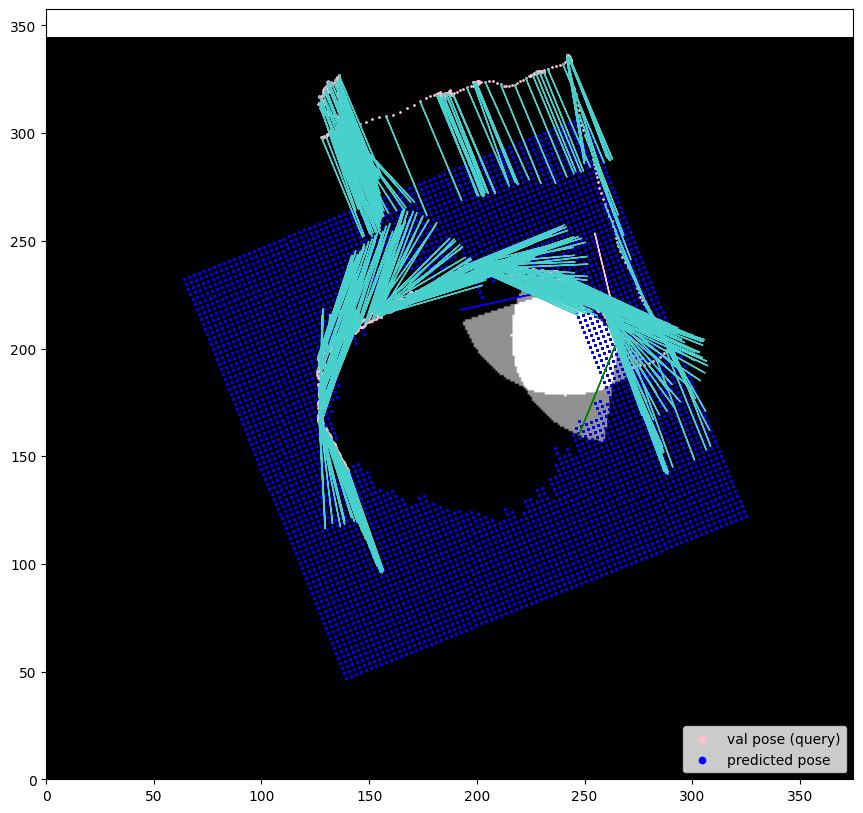

<Figure size 640x480 with 0 Axes>

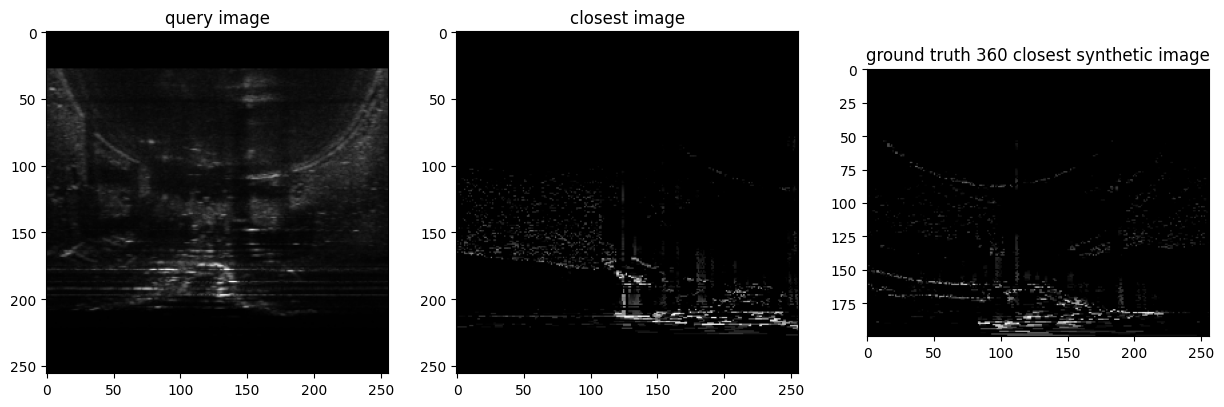

In [67]:
query_idx = imports.random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
real_functions.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [69]:
real_data_train = load_only_real.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real.SonarDescriptorOnlyRealDataset(real_data_train)

In [70]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:08<00:00, 83.24it/s]

descriptors computed!


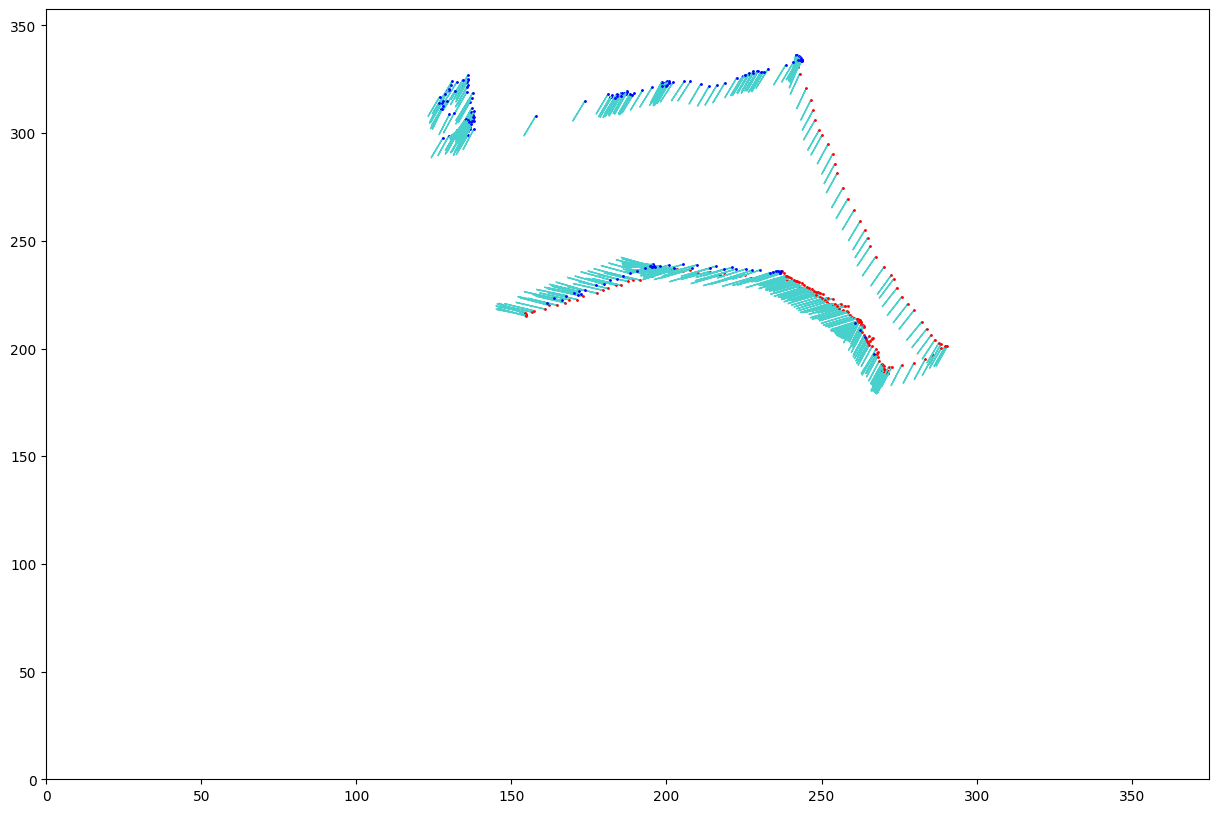

In [71]:
real_functions.visualize_real(train_data, real_data)

iou: 0.008860578577689335
localization error: 9.5560 meters
orientation error : 44.5360 degrees


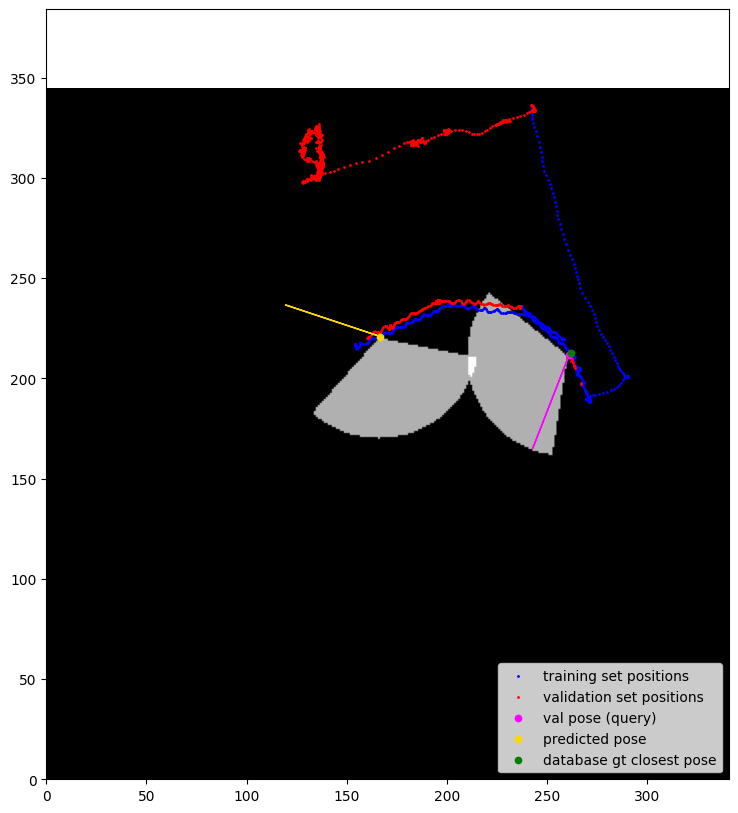

<Figure size 640x480 with 0 Axes>

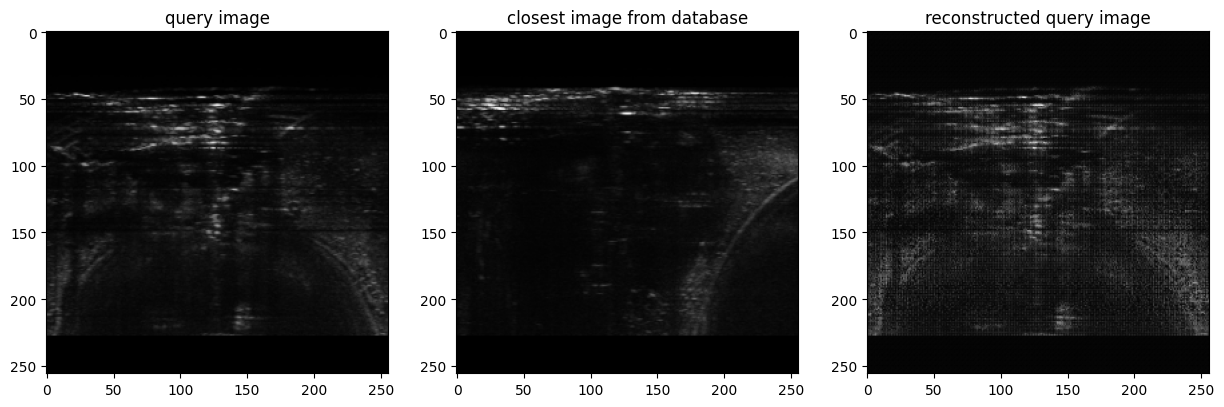

In [72]:
query_idx = imports.random.randint(700, len(real_data_valid))
loca_error, orie_error = real_functions.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [73]:
loca_errors, orie_errors = [], []

for query_idx in imports.tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = real_functions.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = imports.np.array(loca_errors).mean()
avg_orie_error = imports.np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

 20%|████████▏                                | 156/785 [00:04<00:17, 36.64it/s]


KeyboardInterrupt: 

In [74]:
avg_orie_error.min()

np.float32(88.72866)

## K-TOP

In [ ]:
K = 15
bests = database.norms.argsort()

preds = np.zeros((K, 2))
imgs = []
for i in range(K):
    _, img, minpos, _, _, _ = database.dataset[bests[i]]
    preds[i, :] = minpos[:2]
    imgs.append(img)

colors = []
for v in database.norms/database.norms.max():
    colors.append([v, 0, 0])
    
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(query_gtpose[0].item(), query_gtpose[1].item(), c='green',s = 20.51, label="gt query pose")
plt.scatter(preds[:, 0], preds[:, 1], c='blue', s = 20.51, label=f"database predicted {K} closest poses")
plt.legend(loc="lower right")

plt.figure()

f, axarr = plt.subplots(K, 2, figsize=(20, 20))

axarr[0,0].set_title(f"query image")
axarr[0,1].set_title(f"retrieved image")


for i in range(K):

    axarr[i,0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
    axarr[i,1].imshow(imgs[i].numpy()[0, :, :], cmap='gray')